In [8]:
import warnings
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Data 

In [43]:
data = pd.read_csv('Global_Superstore2.csv', encoding = "latin-1")
data.head(7)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical
5,22732,IN-2013-42360,28-06-2013,01-07-2013,Second Class,JM-15655,Jim Mitchum,Corporate,Sydney,New South Wales,...,TEC-PH-10000030,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.675,5,0.1,763.2750,897.35,Critical
6,30570,IN-2011-81826,07-11-2011,09-11-2011,First Class,TS-21340,Toby Swindell,Consumer,Porirua,Wellington,...,FUR-CH-10004050,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.080,4,0.0,564.8400,894.77,Critical


In [3]:
# Removing irrelevant columns
df = data.drop(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
              'Postal Code', 'Product ID', 'Product Name'], axis = 1)
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Date      51290 non-null  object 
 1   Ship Mode       51290 non-null  object 
 2   Segment         51290 non-null  object 
 3   City            51290 non-null  object 
 4   State           51290 non-null  object 
 5   Country         51290 non-null  object 
 6   Market          51290 non-null  object 
 7   Region          51290 non-null  object 
 8   Category        51290 non-null  object 
 9   Sub-Category    51290 non-null  object 
 10  Sales           51290 non-null  float64
 11  Quantity        51290 non-null  int64  
 12  Discount        51290 non-null  float64
 13  Profit          51290 non-null  float64
 14  Shipping Cost   51290 non-null  float64
 15  Order Priority  51290 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 6.3+ MB


In [4]:
# Number of categories in each categorical variable

for i in df:
    if df[i].dtype == ('object' or 'category'):
        print(i, len(df[i].unique()))

Order Date 1430
Ship Mode 4
Segment 3
City 3636
State 1094
Country 147
Market 7
Region 13
Category 3
Sub-Category 17
Order Priority 4


### Monthly sales for all categories 

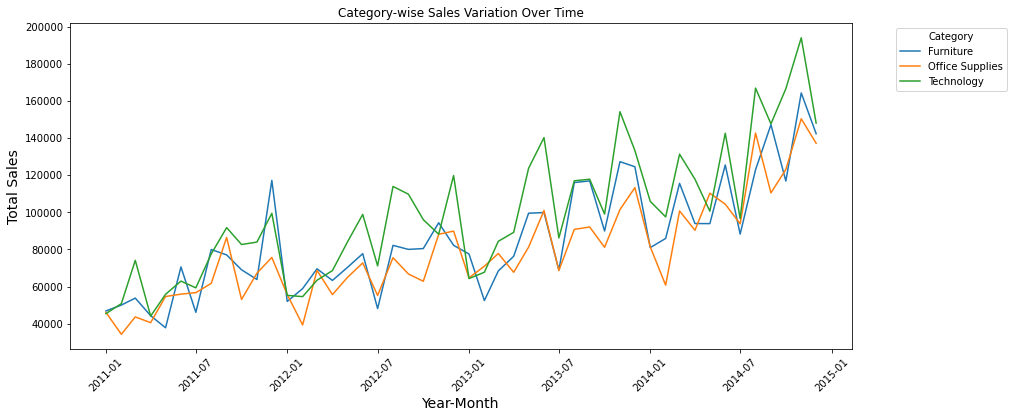

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['YearMonth'] = df['Order Date'].dt.to_period('M')  # setting to monthly steps

# Convert 'YearMonth' to timestamp
df['YearMonth'] = df['YearMonth'].dt.to_timestamp()

category_sales = df.groupby(['YearMonth', 'Category'])['Sales'].sum().reset_index()
sub_category_sales = df.groupby(['YearMonth', 'Category', 'Sub-Category'])['Sales'].sum().reset_index()

plt.figure(figsize = (14, 6))
sns.lineplot(x = 'YearMonth', y = 'Sales', hue = 'Category', data = category_sales, markers = True)
plt.title('Category-wise Sales Variation with time')
plt.xlabel('Year-Month', fontsize = 14)
plt.ylabel('Total Sales', fontsize = 14)
plt.xticks(rotation = 45)
plt.legend(title = 'Category', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### Correlation among numerical features 

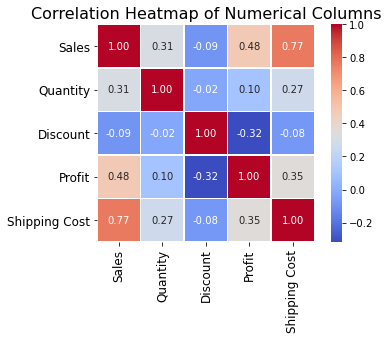

In [6]:
numerical_feat = ['Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost']
numerical_df = df[numerical_feat]

correlation_matrix = numerical_df.corr()

plt.figure(figsize = (6, 4))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = .5, square = True)

plt.title('Correlation Heatmap of Numerical Columns', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()


## K-means clustering based on `sales` and `profit` for customer segmentation  
### WCSS method to obtain optimal number of clusters (k)

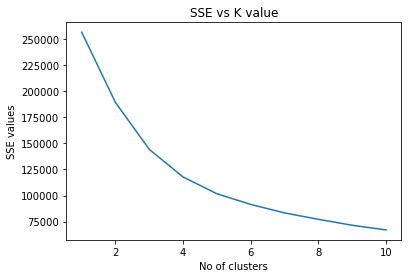

In [13]:
# Create a new DataFrame with selected features (all numerical)
customer_data = df[numerical_feat]

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# WCSS method for finding the optimal k
sse = []
for k in range(1, 11):
    k_means = KMeans(n_clusters = k, n_init = 10)
    k_means.fit(scaled_data)  # Use fit instead of fit_predict
    sse.append(k_means.inertia_)
    
plt.plot(range(1, 11), sse)
plt.xlabel("No of clusters")
plt.ylabel("SSE values")
plt.title("SSE vs K value")
plt.show()

In [15]:
# Choose the number of clusters (K)
k = 4
kmeans = KMeans(n_clusters = k, random_state = 42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

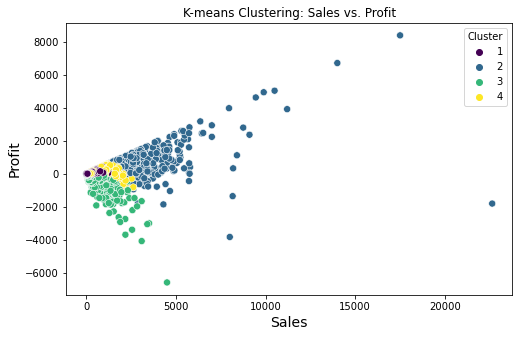

In [90]:
# Scatter plot for 'Sales' and 'Profit' colored by clusters
plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'Sales', y = 'Profit', hue = 'Cluster', s = 50,
                data = df, palette = 'viridis', alpha = 1)
plt.title('K-means Clustering: Sales vs. Profit')
plt.xlabel('Sales', fontsize = 15)
plt.ylabel('Profit', fontsize = 15)
plt.show()

## Creating time series cross validation splits for each cluster  

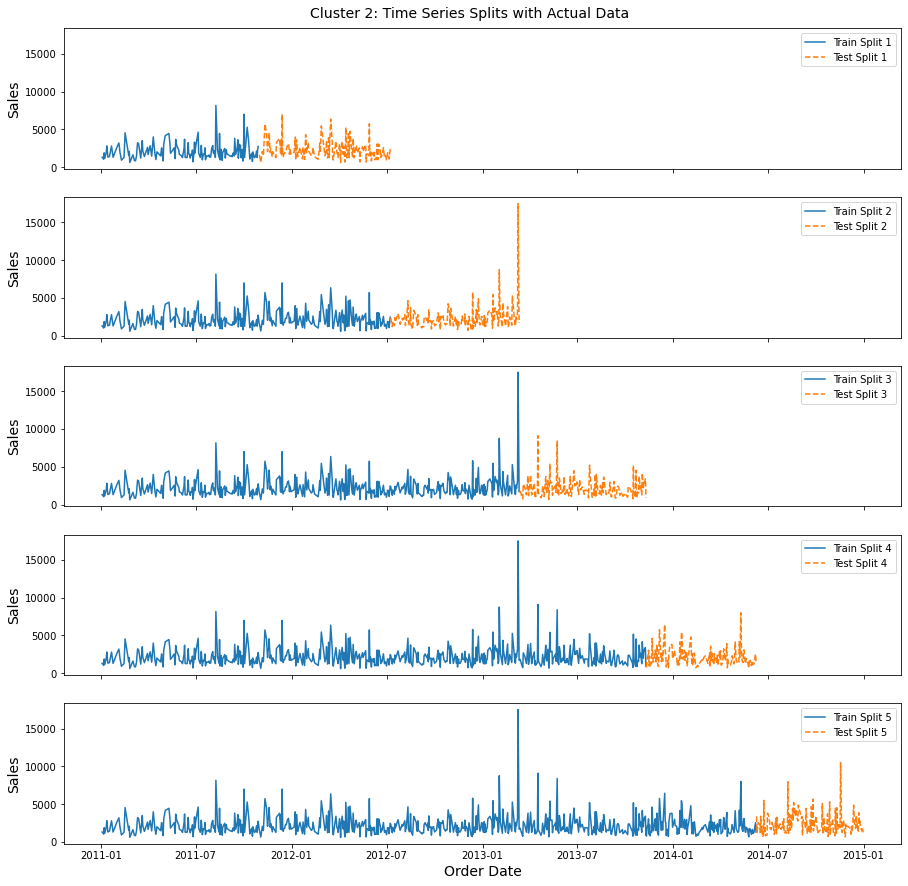

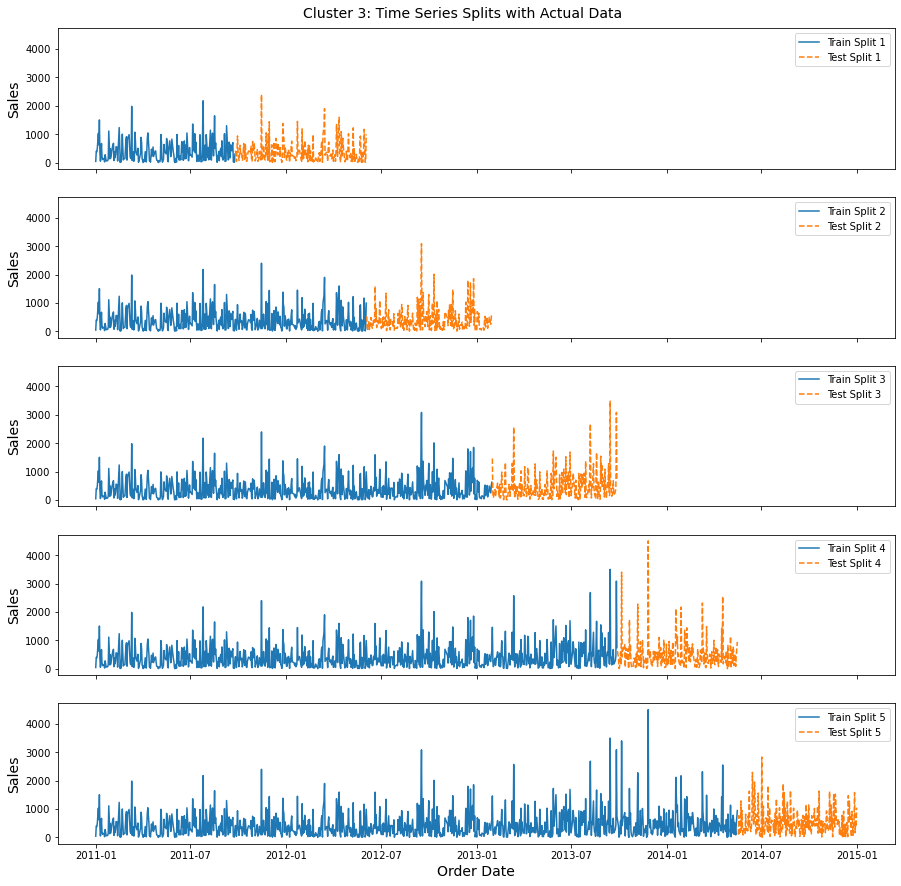

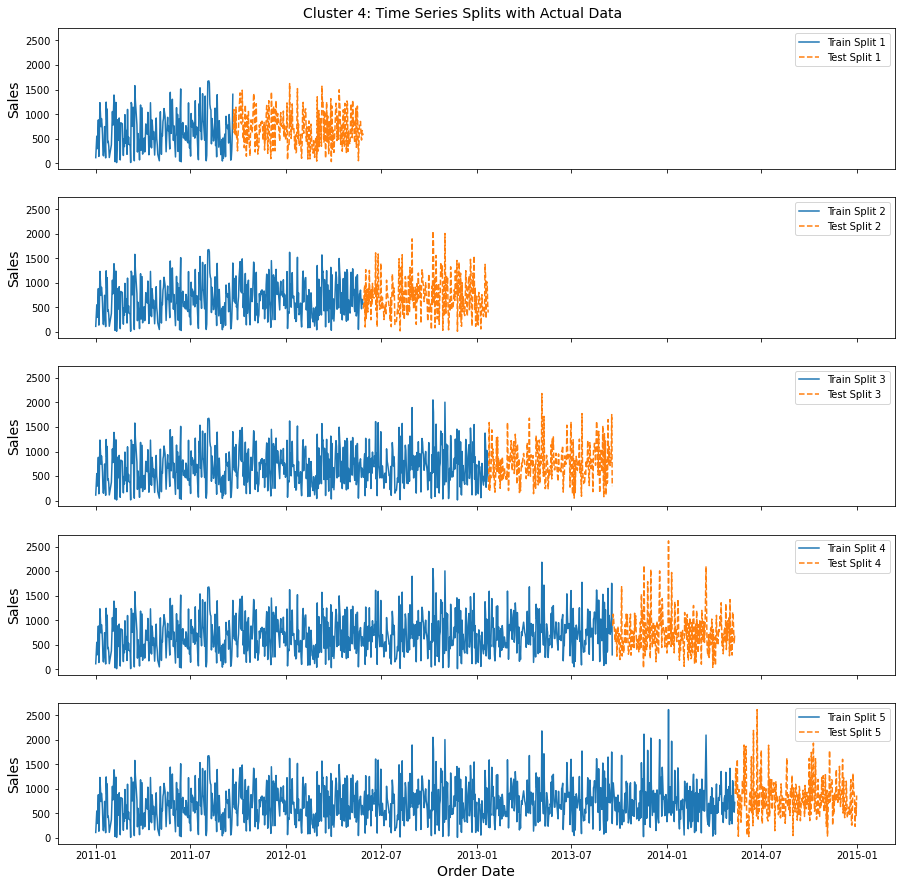

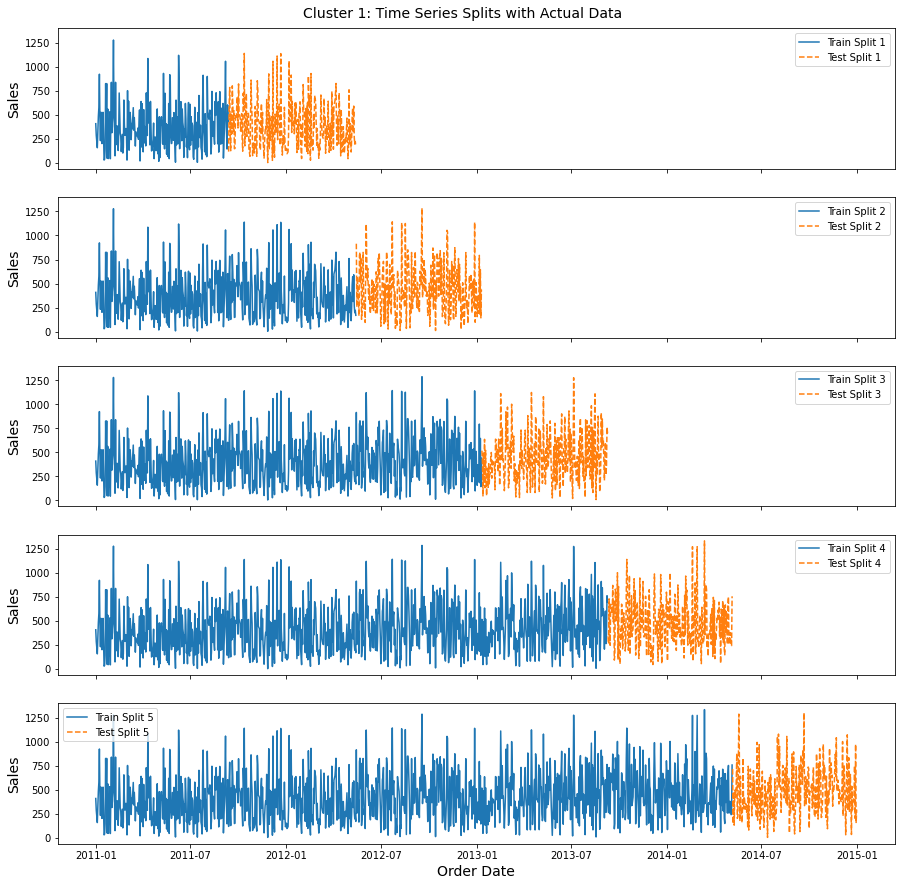

In [176]:
cluster_data = {}
cluster_models = {} 

for cluster_label in df['Cluster'].unique():    # Iterating over each cluster's data as obtained from k-means
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder() 
    categorical_features = ["Ship Mode", "Segment", "Market", "Category", "Order Priority"] # Adding select categorical features
     
    for feature in categorical_features:        # Encoding the cateogrical features                                           
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]   
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features    # total features
    selected_features += ['Order Date']
    
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index() #Grouping by each date
    
    X = cluster_data[cluster_label][selected_features[1:]]    # feature set
    y = cluster_data[cluster_label]['Sales']                  # target variable

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits = 5)

    fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize = (15, 15), sharex = True, sharey = True)
    fig.suptitle(f'Cluster {cluster_label}: Time Series Splits with Actual Data', y = 0.9, fontsize = 14)

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[train_index],
            y.iloc[train_index],
            label = f'Train Split {i + 1}'
        )

        ax.plot(
            cluster_data[cluster_label]['Order Date'].iloc[test_index],
            y.iloc[test_index],
            label = f'Test Split {i + 1}',
            linestyle = 'dashed'
        )

        ax.set_ylabel('Sales', fontsize = 14)
        ax.legend()

    plt.xlabel('Order Date', fontsize = 14)
    plt.show()

## Predicting `Sales` for each cluster (customer segment) using XGBoost regression along with hyperparameter tuning

In [177]:
warnings.filterwarnings("ignore")

Best model parameters for cluster 1 are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


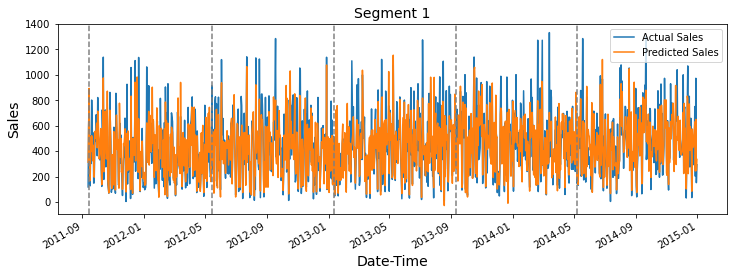

Average MAPE for segment 1: 30.770735215444642
Average RMSPE for segment 1: 86.35691579335828

Best model parameters for cluster 2 are: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


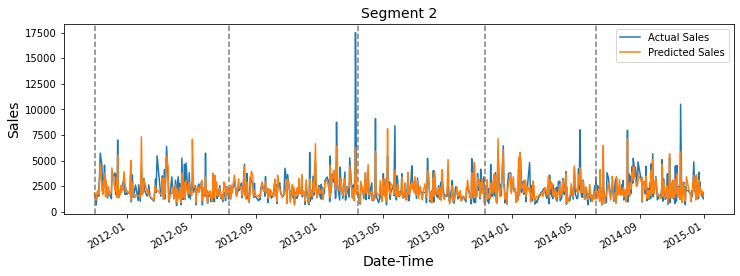

Average MAPE for segment 2: 22.042435449972423
Average RMSPE for segment 2: 28.662307436199747

Best model parameters for cluster 3 are: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


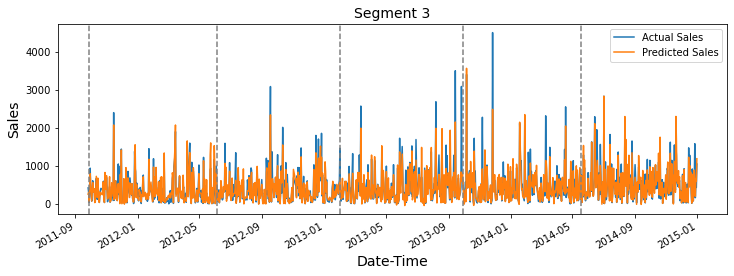

Average MAPE for segment 3: 43.346754900274696
Average RMSPE for segment 3: 170.08012026116322

Best model parameters for cluster 4 are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


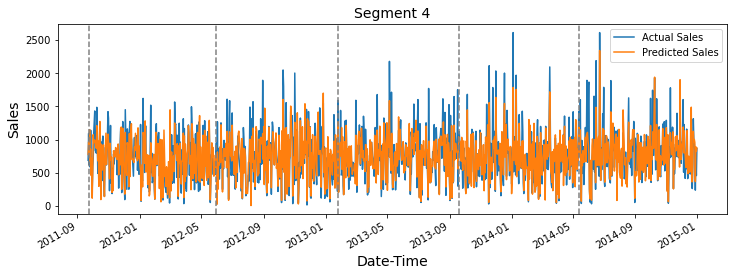

Average MAPE for segment 4: 27.14906989375575
Average RMSPE for segment 4: 40.134936022113926



In [209]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [1, 3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

unique_clusters = sorted(df['Cluster'].unique())
cluster_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(unique_clusters)}
df['Cluster'] = df['Cluster'].map(cluster_mapping)

cluster_data = {}   # Initialize cluster_data dictionary
feature_importance_data = {}   # To store feature importances for each cluster predictions

for cluster_label in unique_clusters:
    cluster_data[cluster_label] = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder()
    for feature in categorical_features:
        cluster_data[cluster_label][f'{feature}_Encoded'] = label_encoder.fit_transform(
            cluster_data[cluster_label][feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
    encoded_features = [f'{feature}_Encoded' for feature in categorical_features]
    selected_features = numerical_features + encoded_features
    selected_features += ['Order Date']

    cluster_data[cluster_label] = cluster_data[cluster_label][selected_features]
    cluster_data[cluster_label] = cluster_data[cluster_label].groupby('Order Date').first().reset_index()  # Grouping by each date

    x = cluster_data[cluster_label][selected_features[1:]]  # feature set (excluding target 'sales' column)
    y = cluster_data[cluster_label]['Sales']  # target variable

    # Extract relevant information from 'Order Date' (feature engineering for time series)
    x['Order Date'] = pd.to_datetime(x['Order Date'])
    x['Year'] = x['Order Date'].dt.year
    x['Month'] = x['Order Date'].dt.month
    x['Day'] = x['Order Date'].dt.day
    x['DayOfWeek'] = x['Order Date'].dt.dayofweek

    X = x.drop(['Order Date'], axis=1)

    # Initialize XGBoost model
    model = XGBRegressor()

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=tscv)
    grid_search.fit(X, y)

    # Obtaining the best parameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best model parameters for cluster {cluster_label} are: {best_params}")

    # Train the model with the best parameters
    best_model = XGBRegressor(**best_params)

    # Fit the model once before using it for predictions
    best_model.fit(X, y)

    feature_importance = best_model.feature_importances_   # Get feature importance scores
    feature_names = X.columns                              # Get feature names
    feature_importance_data[cluster_label] = {'feature_names': feature_names, 'importance': feature_importance}

    avg_mape, avg_rmspe = [], []
    all_actual_values, all_predicted_values, all_dates = [], [], [] 

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)  # Predictions on test set (CV split)

        # Model evaluation using MAPE and RMSPE
        actual_values = y.loc[X_test.index]  # Align with the original index
        percentage_errors = abs((actual_values - y_pred) / actual_values) * 100
        mape = percentage_errors.mean()
        avg_mape.append(mape)
        rmspe = math.sqrt((percentage_errors ** 2).mean())
        avg_rmspe.append(rmspe)

        # Combine actual and predicted values for the time series
        sorted_indices = x.iloc[test_index].index.argsort()  # Sorting based on the index
        sorted_dates = x.iloc[test_index]['Order Date'].iloc[sorted_indices]
        sorted_y_test = y_test.iloc[sorted_indices]
        sorted_y_pred = pd.Series(y_pred, index=sorted_dates)

        all_actual_values.extend(sorted_y_test)
        all_predicted_values.extend(sorted_y_pred)
        all_dates.extend(sorted_dates)

    # Plot combined time series with vertical lines
    plt.figure(figsize=(12, 3.5))
    plt.plot(all_dates, all_actual_values, label='Actual Sales', color='#1f77b4')
    plt.plot(all_dates, all_predicted_values, label='Predicted Sales', color='#ff7f0e')

    # Add vertical lines to indicate cross-validation folds
    for i in range(1, len(all_dates), len(test_index)):
        plt.axvline(x=all_dates[i], color='gray', linestyle='--')

    plt.xticks(rotation=30, ha='right')
    plt.title(f'Segment {cluster_label}', fontsize=14)
    plt.xlabel('Date-Time', fontsize=14)
    plt.ylabel('Sales', fontsize=14)
    plt.xticks(fontsize=9)
    plt.xticks(fontsize=10)
    plt.legend()
    #plt.savefig(f'figure_segment_{cluster_label}.jpg', dpi = 600)
    plt.show()

    # Calculate average MAPE and RMSPE for the cluster
    percentage_errors = abs((np.array(all_actual_values) - np.array(all_predicted_values)) / np.array(all_actual_values)) * 100
    avg_mape = percentage_errors.mean()
    avg_rmspe = np.sqrt((percentage_errors ** 2).mean())

    print(f"Average MAPE for segment {cluster_label}: {avg_mape}")
    print(f"Average RMSPE for segment {cluster_label}: {avg_rmspe}")
    print("")

### Feature importances in each customer segment

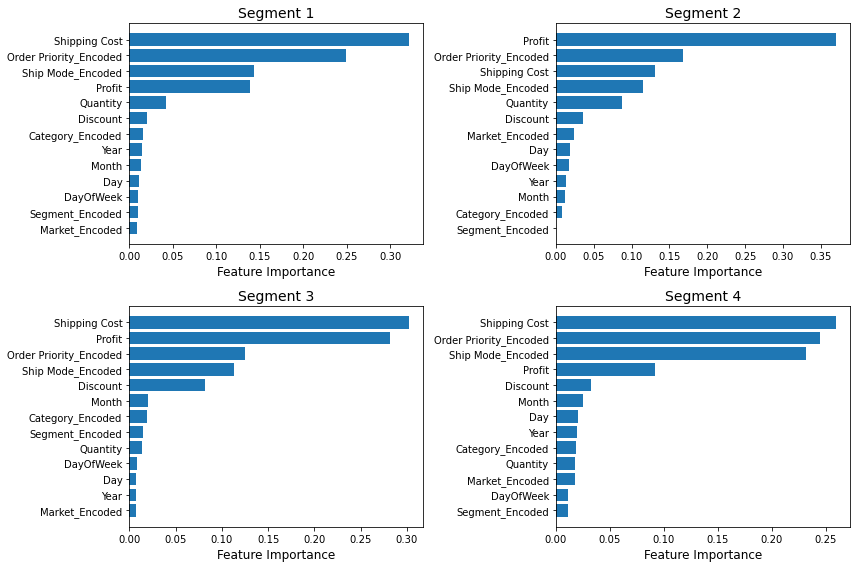

In [210]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))

for i, (cluster_label, importance_info) in enumerate(feature_importance_data.items()):
    feature_names = importance_info['feature_names']
    importance = importance_info['importance']

    row = i // 2
    col = i % 2

    axes[row, col].barh(range(len(feature_names)), importance[np.argsort(importance)])
    axes[row, col].set_yticks(range(len(feature_names)))
    axes[row, col].set_yticklabels(np.array(feature_names)[np.argsort(importance)])
    axes[row, col].set_xlabel('Feature Importance', fontsize=12)
    axes[row, col].set_title(f'Segment {cluster_label}', fontsize=14)

plt.tight_layout()
plt.show()

## Weekly aggregated sales (demand) prediction 

Best model parameters for cluster 1 are: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 500}


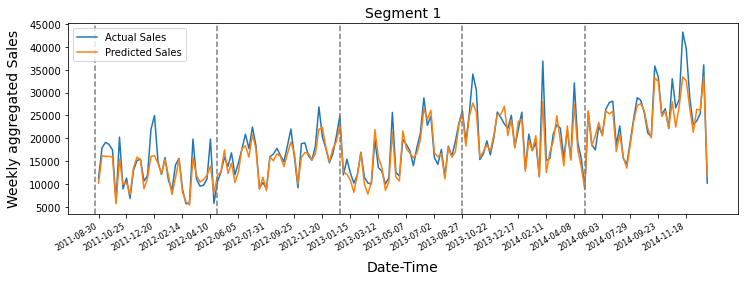

Average MAPE for segment 1: 8.500886588928811
Average RMSPE for segment 1: 10.579822896167864

Best model parameters for cluster 2 are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


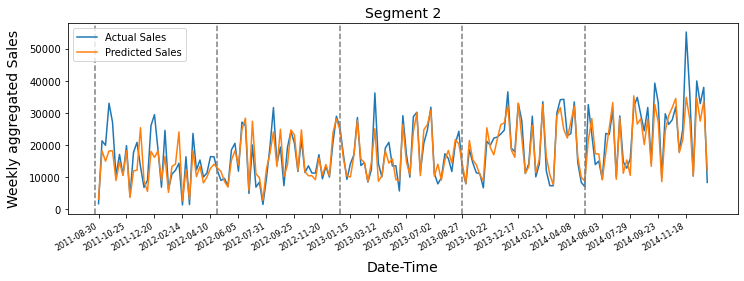

Average MAPE for segment 2: 18.70827519748844
Average RMSPE for segment 2: 24.819053735024465

Best model parameters for cluster 3 are: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 1000}


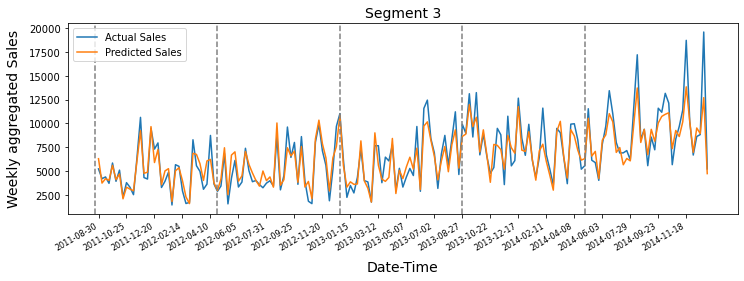

Average MAPE for segment 3: 15.564845087207496
Average RMSPE for segment 3: 20.505049213727794

Best model parameters for cluster 4 are: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 1000}


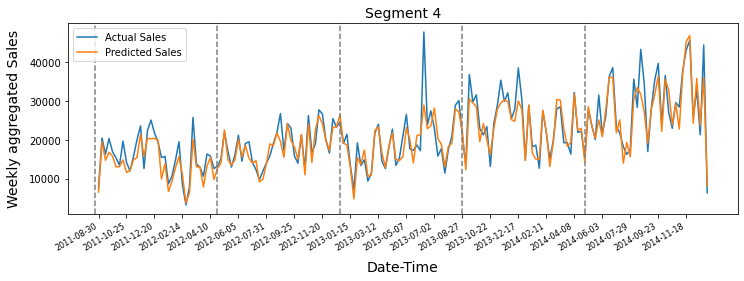

Average MAPE for segment 4: 10.90480985308014
Average RMSPE for segment 4: 13.645867744126928



In [211]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [1, 3, 5, 10],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

# Get unique cluster labels and sort them
#unique_clusters = sorted(df['Cluster'].unique())
#cluster_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(unique_clusters)}
#df['Cluster'] = df['Cluster'].map(cluster_mapping)

feature_importance_weeklydata = {}  

for cluster_label in unique_clusters:
    cluster_data = df[df['Cluster'] == cluster_label].copy()

    label_encoder = LabelEncoder()
    for feature in categorical_features:
        cluster_data[f'{feature}_Encoded'] = label_encoder.fit_transform(cluster_data[feature])

    numerical_features = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
    numerical_features += ['Order Date']

    cluster_data = cluster_data[numerical_features]

    # Group by week and aggregate sales
    cluster_data['Week_Start'] = cluster_data['Order Date'].dt.to_period('W-Mon').dt.start_time
    cluster_data = cluster_data.groupby('Week_Start').agg({
        'Sales': 'sum',
        'Quantity': 'sum',
        'Discount': 'mean',
        'Profit': 'sum',
        'Shipping Cost': 'mean'
    }).reset_index()

    numerical_features.remove('Order Date')  # order date is no longer needed

    # Add 'Week_Start' to numerical features after aggregation
    numerical_features += ['Week_Start']

    x = cluster_data[numerical_features[1 :]]  # feature set (excluding sales' and 'order date' column)
    y = cluster_data['Sales']  # target variable
    x['Week_Start'] = pd.to_datetime(x['Week_Start'])
    X = x.drop(['Week_Start'], axis=1)

    model = XGBRegressor()

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv = tscv)
    grid_search.fit(X, y)

    # Obtaining the best parameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best model parameters for cluster {cluster_label} are: {best_params}")

    # Train the model with the best parameters
    best_model = XGBRegressor(**best_params)
    best_model.fit(X, y)  # Fit the model before using it

    
    feature_imp_weekly = best_model.feature_importances_   # Get feature importance scores 
    feature_names = X.columns   # Get feature names
    feature_importance_weeklydata[cluster_label] = {'feature_names': feature_names, 'importance': feature_imp_weekly}

    avg_mape, avg_rmspe = [], []

    plt.figure(figsize=(12, 3.5))

    all_sorted_dates = []  # To store all dates for setting x-axis ticks later
    all_actual_values = []  # To store all actual values
    all_predicted_values = []  # To store all predicted values

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)  # Predictions on test set (CV split)

        # Model evaluation using MAPE and RMSPE
        actual_values = y.loc[X_test.index]  # Align with the original index
        percentage_errors = abs((actual_values - y_pred) / actual_values) * 100

        mape = percentage_errors.mean()
        avg_mape.append(mape)

        rmspe = math.sqrt((percentage_errors ** 2).mean())
        avg_rmspe.append(rmspe)

        sorted_indices = x.iloc[test_index].index.argsort()  # Sorting based on the index
        sorted_dates = x.iloc[test_index]['Week_Start'].iloc[sorted_indices]
        all_sorted_dates.extend(sorted_dates)  # Add all dates to the list
        all_actual_values.extend(y_test.iloc[sorted_indices])  # Add all actual values
        all_predicted_values.extend(y_pred)  # Add all predicted values

    # Plot actual and predicted values for the entire series
    plt.plot(all_sorted_dates, all_actual_values, label=f'Actual Sales', color = '#1f77b4')
    plt.plot(all_sorted_dates, all_predicted_values, label=f'Predicted Sales', color = '#ff7f0e')

    # Plot vertical lines to indicate cross-validation folds
    for split_point in tscv.split(X):
        split_date = x.iloc[split_point[0][-1]]['Week_Start']
        plt.axvline(x=split_date, color='gray', linestyle='--')

    # Set x-axis ticks using a subset of dates
    subset_size = min(20, len(all_sorted_dates))
    step = len(all_sorted_dates) // subset_size
    subset_dates = all_sorted_dates[::step]
    plt.xticks(subset_dates, rotation=30, ha='right')

    plt.title(f'Segment {cluster_label}', fontsize = 14)
    plt.xlabel('Date-Time', fontsize = 14, labelpad = 8)
    plt.ylabel('Weekly aggregated Sales', fontsize = 14, labelpad = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 10)
    plt.legend(loc = 'upper left')
    plt.show()

    print(f"Average MAPE for segment {cluster_label}: {sum(avg_mape) / len(avg_mape)}")
    print(f"Average RMSPE for segment {cluster_label}: {sum(avg_rmspe) / len(avg_rmspe)}")
    print("")

### Feature importances

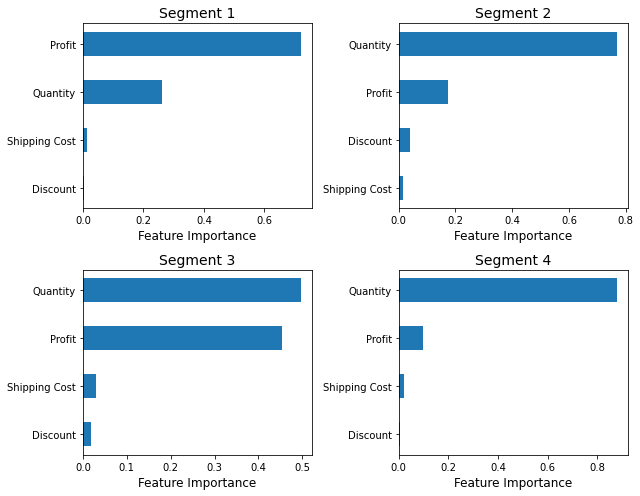

In [212]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

for i, (cluster_label, importance_info) in enumerate(feature_importance_weeklydata.items()):
    feature_names = importance_info['feature_names']
    importance = importance_info['importance']

    row = i // 2
    col = i % 2

    axes[row, col].barh(range(len(feature_names)), importance[np.argsort(importance)], height = 0.5)
    axes[row, col].set_yticks(range(len(feature_names)))
    axes[row, col].set_yticklabels(np.array(feature_names)[np.argsort(importance)])
    axes[row, col].set_xlabel('Feature Importance', fontsize=12)
    axes[row, col].set_title(f'Segment {cluster_label}', fontsize=14)

plt.tight_layout()
plt.show()